In [1]:
import csv 
import networkx as nx
import matplotlib.pyplot as plt
import math
from graph import Graph
from article import Article
import random
import pandas as pd
import seaborn as sns
import mplcursors 
import numpy as np
from tqdm import tqdm

In [2]:
cs_graph = Graph()
cs_graph.update_graph("data/categories.tsv", mode='Initialization')
cs_graph.update_graph("data/paths_finished.tsv", mode='common_sense_edges', verbose=True,paths_mode=True) 
cs_graph.update_graph("data/paths_unfinished.tsv", mode='common_sense_edges', verbose=True,paths_mode=True,finished=False)

The graph has 4599 articles, 127 categories, and 15 topics.
The number of edges is :
50354 in the articles graph,
6530 in the categories graph,
208 in the topics graph.
The graph has 4599 articles, 127 categories, and 15 topics.
The number of edges is :
57572 in the articles graph,
6931 in the categories graph,
208 in the topics graph.


In [3]:
links_df = pd.read_csv('data/links_df_filtered.csv')

In [4]:
len(links_df)

89080

In [5]:
def divide_column_into_bins(df, column, bin_size):
  # Create the bins
  bins = range(0, int(df[column].max()) + bin_size, bin_size)

  # Create a new column that contains the binned values
  df["binned"] = pd.cut(df[column], bins)

  return df

In [6]:

dict_paths = {}
paths = cs_graph.paths

paths_positions = []
print(len(paths))
groups = links_df.groupby(['article_from','article_to'])
nbr_errors = 0
for i in tqdm(range(0,len(paths)-1)):
    
    pos = []
    relative_pos = []
    for j in range(0,len(paths[i])-1):
        try:
            temp_df = groups.get_group((paths[i][j],paths[i][j+1]))
        except Exception as e:
            nbr_errors += 1
            pos.append(np.nan)
            relative_pos.append(np.nan)
            continue
        pos.append(temp_df['position'].item())
        relative_pos.append(temp_df['relative_position'].item())
    pos_mean = np.nanmean(pos)
    relative_mean = np.nanmean(relative_pos)
    dict_paths[i] = [paths[i],len(paths[i]),pos,pos_mean,relative_pos,relative_mean,cs_graph.finished[i]]
print(nbr_errors)

76193


  0%|          | 31/76192 [00:00<04:05, 309.78it/s]/var/folders/zp/t_7t2xyj4n760sxfr2jkq6z40000gn/T/ipykernel_3508/871449411.py:22: RuntimeWarning: Mean of empty slice
  pos_mean = np.nanmean(pos)
/var/folders/zp/t_7t2xyj4n760sxfr2jkq6z40000gn/T/ipykernel_3508/871449411.py:23: RuntimeWarning: Mean of empty slice
  relative_mean = np.nanmean(relative_pos)
100%|██████████| 76192/76192 [00:16<00:00, 4541.73it/s]

149486


In [7]:
paths_df = pd.DataFrame.from_dict(dict_paths, orient='index', columns=['paths', 'path_length', 'link_positions','position_mean','relative_pos','relative_mean','finished'])

In [8]:
paths_df.sample(10)

,paths,path_length,link_positions,position_mean,relative_pos,relative_mean,finished
63288,"[Euro, European_Union]",2,[nan],NaN,[nan],NaN,False
18766,"[Viking, Europe, Culture, Ancient_Greece, Musi...",9,"[nan, 74, nan, 60, 8, 4, nan, 2]",29.600000,"[nan, 47.0, nan, 92.0, 33.0, 50.0, nan, 9.0]",46.200000,True
7741,"[The_Bahamas, Atlantic_Ocean, Europe, Greek_my...",5,"[6, 9, 69, nan]",28.000000,"[22.0, 7.000000000000001, 43.0, nan]",24.000000,True
19821,"[European_Union, Belgium, Flemish_people]",3,"[nan, 41]",41.000000,"[nan, 67.0]",67.000000,True
75238,"[Montserrat, Beach, Sport, Olympic_Games]",4,"[22, 7, nan]",14.500000,"[85.0, 32.0, nan]",58.500000,False
72648,"[Theatre, Opera, Richard_Wagner, William_Shake...",12,"[nan, nan, nan, nan, nan, 4, 25, 22, nan, 12, ...",15.750000,"[nan, nan, nan, nan, nan, 31.0, 22.0, 19.0, na...",21.500000,False
6232,"[Metal, Chemical_element, Alchemy, Ancient_Rom...",5,"[nan, 18, nan, 67]",42.500000,"[nan, 53.0, nan, 76.0]",64.500000,True
7394,"[Senegal, France, United_Kingdom, Tennis]",4,"[nan, nan, nan]",NaN,"[nan, nan, nan]",NaN,True
6792,"[Pacific_Ocean, Tuna, Mercury_%28element%29, F...",7,"[72, nan, 13, nan, nan, nan]",42.500000,"[83.0, nan, 20.0, nan, nan, nan]",51.500000,True
55538,"[Pyramid, Ancient_Egypt, Agriculture, Soybean,...",5,"[nan, 21, 42, 1]",21.333333,"[nan, 31.0, 74.0, 2.0]",35.666667,False


# Part 1 : Explore won games

In [9]:
# remve paths with only one link
paths_df = paths_df[paths_df['path_length'] > 1]

# remove unfinished paths
paths_df = paths_df[paths_df['finished'] == True]

# print the number of paths
print(len(paths_df))

51307


In [10]:
paths_df.sample(20)

,paths,path_length,link_positions,position_mean,relative_pos,relative_mean,finished
6479,"[Nazi_Germany, United_Kingdom, England]",3,"[nan, nan]",NaN,"[nan, nan]",NaN,True
32876,"[Gettysburg_Address, Washington%2C_D.C., Thail...",7,"[nan, 47, nan, nan, 1, nan]",24.000000,"[nan, 68.0, nan, nan, 5.0, nan]",36.500000,True
20358,"[Pyramid, Mexico, Agriculture, Food, Cereal, S...",7,"[6, 26, nan, 10, nan, 3]",11.250000,"[35.0, 39.0, nan, 24.0, nan, 10.0]",27.000000,True
11056,"[East_Africa, France, Paris, Pablo_Picasso, Ar...",9,"[41, nan, nan, 2, nan, nan, nan, 5]",16.000000,"[87.0, nan, nan, 11.0, nan, nan, nan, 42.0]",46.666667,True
45264,"[Podcasting, Internet, United_States, U.S._sta...",5,"[3, 4, nan, nan]",3.500000,"[30.0, 12.0, nan, nan]",21.000000,True
29911,"[Tuvalu, United_Nations, Spanish_language, Par...",4,"[13, nan, nan]",13.000000,"[45.0, nan, nan]",45.000000,True
13729,"[Tyrannosaurus, Mammal, Brain, Medicine, Eye, ...",8,"[17, 8, 36, 24, nan, 5, nan]",18.000000,"[36.0, 19.0, 67.0, 53.0, nan, 71.0, nan]",49.200000,True
22909,"[William_IV_of_the_United_Kingdom, British_Emp...",5,"[8, 3, nan, 51]",20.666667,"[30.0, 2.0, nan, 17.0]",16.333333,True
41151,"[James_Garfield, Chemistry, Calculus, Isaac_Ne...",9,"[3, 26, nan, nan, nan, 5, 38, nan]",18.000000,"[17.0, 53.0, nan, nan, nan, 19.0, 61.0, nan]",37.500000,True
41484,"[Jonah_Lomu, New_Zealand, United_Kingdom, Lond...",9,"[nan, nan, nan, nan, 1, nan, 7, nan]",4.000000,"[nan, nan, nan, nan, 6.0, nan, 57.999999999999...",32.000000,True


In [11]:
def check_nan(L):
    for i in L:
        if math.isnan(i):
            return True

    return False

In [12]:
paths_df['contains_nan'] = paths_df.apply(lambda row: check_nan(row['link_positions']),axis=1)
paths_df = paths_df[~ paths_df['contains_nan']]

In [13]:
len(paths_df)

5660

In [14]:
paths_df.describe()

,path_length,position_mean,relative_mean
count,5660.000000,5660.000000,5660.000000
mean,4.267138,25.116995,43.441941
std,1.404942,18.791941,17.472479
min,2.000000,0.000000,0.000000
25%,3.000000,12.750000,31.500000
50%,4.000000,20.500000,43.000000
75%,5.000000,32.000000,54.750000
max,12.000000,255.000000,97.000000


Keep only paths with length at most 8 as others are few

In [15]:
filtered_paths_df = paths_df[paths_df['path_length']<8]

In [16]:
len(filtered_paths_df)

5504

In [17]:
filtered_paths_df.head()

,paths,path_length,link_positions,position_mean,relative_pos,relative_mean,finished,contains_nan
8,"[14th_century, Time, Light, Rainbow]",4,"[3, 34, 13]",16.666667,"[10.0, 81.0, 24.0]",38.333333,True,False
9,"[14th_century, 15th_century, Plato, Nature, Ul...",7,"[1, 27, 24, 28, 2, 6]",14.666667,"[3.0, 47.0, 55.00000000000001, 41.0, 6.0, 32.0]",30.666667,True,False
12,"[14th_century, Time, Astronomy, Light, Rainbow]",5,"[3, 10, 42, 13]",17.000000,"[10.0, 24.0, 56.00000000000001, 24.0]",28.500000,True,False
21,"[14th_century, Christianity, Religion, Astrolo...",7,"[16, 0, 41, 10, 9, 6]",13.666667,"[52.0, 0.0, 87.0, 21.0, 16.0, 32.0]",34.666667,True,False
22,"[14th_century, Time, Light, Rainbow]",4,"[3, 34, 13]",16.666667,"[10.0, 81.0, 24.0]",38.333333,True,False


In [18]:
filtered_paths_df['position_mean'].mean()

25.290649224806202

<AxesSubplot: xlabel='path_length', ylabel='Count'>

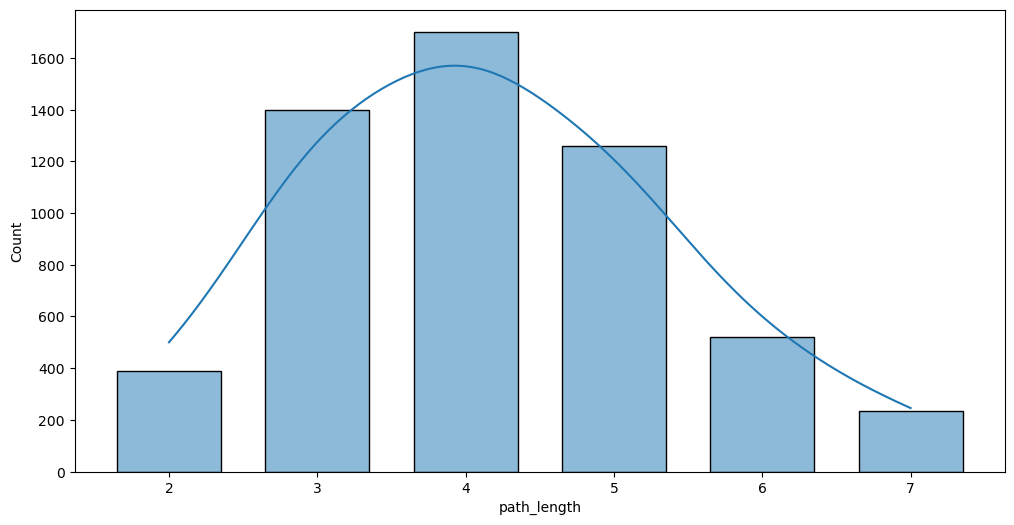

In [75]:
sns.histplot(data=filtered_paths_df, x="path_length",bins=35,stat = 'count',discrete= True, shrink=0.7,
  multiple="dodge", palette="flare", kde=True, kde_kws={'bw_method': 0.5})

/var/folders/zp/t_7t2xyj4n760sxfr2jkq6z40000gn/T/ipykernel_3508/2668720481.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=filtered_paths_df, x="path_length", y="position_mean", palette="flare",)


<AxesSubplot: xlabel='path_length', ylabel='position_mean'>

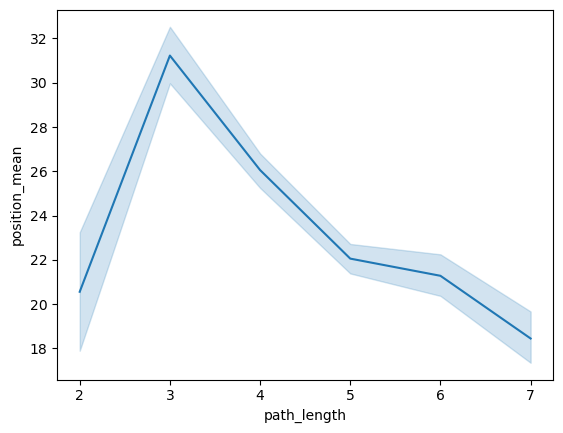

In [20]:
# plot average position_mean for each path length with line
sns.lineplot(data=filtered_paths_df, x="path_length", y="position_mean", palette="flare",)
#sns.barplot(x="path_length", y="position_mean", data=filtered_paths_df, palette="flare",)



<AxesSubplot: xlabel='relative_mean', ylabel='path_length'>

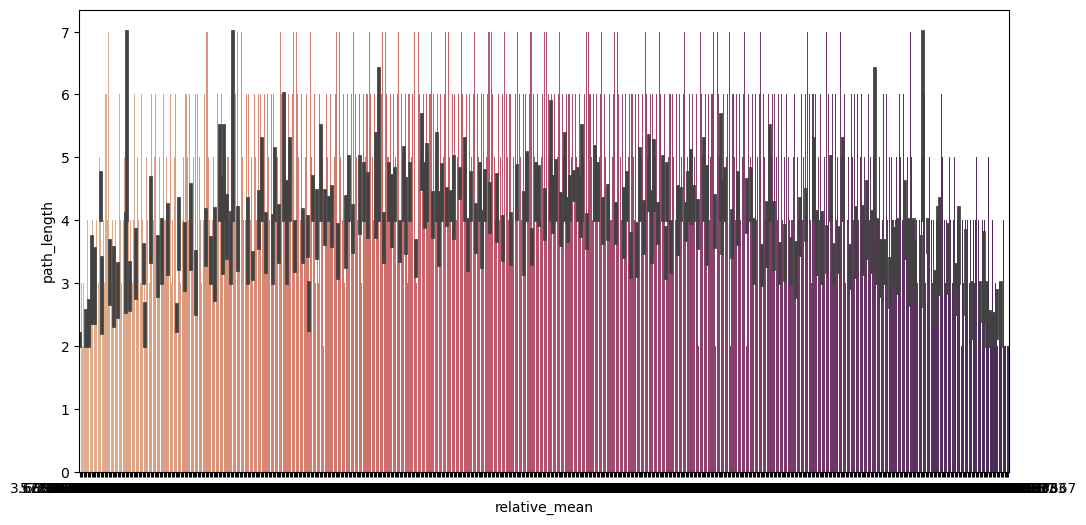

In [77]:
# plot average relative_mean for each path length
sns.barplot(x="relative_mean", y="path_length", data=filtered_paths_df, palette="flare")


<AxesSubplot: xlabel='path_length', ylabel='position_mean'>

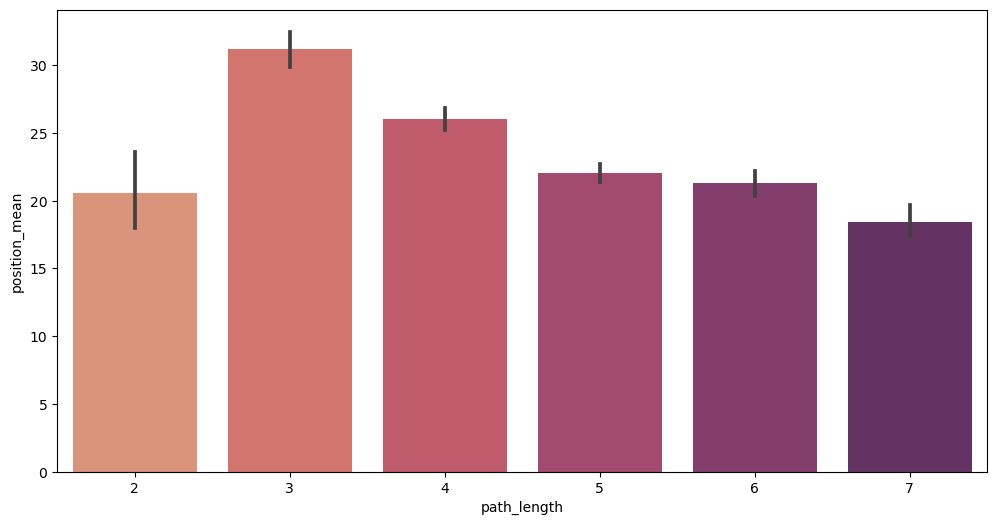

In [76]:
sns.barplot(x="path_length", y="position_mean", data=filtered_paths_df, palette="flare")


In [22]:

paths_df = pd.read_pickle('data/df_paths_finished.pkl')

In [23]:
paths_df

,path,start,end,length
0,"[14th_century, 15th_century, 16th_century, Pac...",14th_century,African_slave_trade,9
1,"[14th_century, Europe, Africa, Atlantic_slave_...",14th_century,African_slave_trade,5
2,"[14th_century, Niger, Nigeria, British_Empire,...",14th_century,African_slave_trade,8
3,"[14th_century, Renaissance, Ancient_Greece, Gr...",14th_century,Greece,4
4,"[14th_century, Italy, Roman_Catholic_Church, H...",14th_century,John_F._Kennedy,7
...,...,...,...,...
42261,"[Work_%28thermodynamics%29, Energy, Aristotle,...",Work_%28thermodynamics%29,Film,13
42262,"[Yagan, Ancient_Egypt, Civilization]",Yagan,Civilization,3
42263,"[Yagan, Australia, England, France, United_Sta...",Yagan,U.S._Open_%28tennis%29,7
42264,"[Yarralumla%2C_Australian_Capital_Territory, A...",Yarralumla%2C_Australian_Capital_Territory,Abraham_Lincoln,4


In [24]:
groups = links_df.groupby(['article_from','article_to'])
def get_link_positions(path,groups) : 

    positions = []
    for i in range(0,len(path)-1):
        try:
            temp_df = groups.get_group((path[i],path[i+1]))
        except Exception as e:
         
            positions.append(np.nan)
            continue
        positions.append(temp_df['position'].item())
        
    return positions

In [25]:
def get_link_relative_positions(path,groups) : 

    positions = []
    for i in range(0,len(path)-1):
        try:
            temp_df = groups.get_group((path[i],path[i+1]))
        except Exception as e:
         
            positions.append(np.nan)
            continue
        positions.append(temp_df['relative_position'].item())
        
    return positions

In [26]:
paths_df['positions'] = paths_df['path'].apply(lambda x: get_link_positions(x,groups)) 

In [27]:
paths_df['relative_postions'] = paths_df['path'].apply(lambda x: get_link_relative_positions(x,groups))

In [28]:
paths_df

,path,start,end,length,positions,relative_postions
0,"[14th_century, 15th_century, 16th_century, Pac...",14th_century,African_slave_trade,9,"[1, nan, 60, nan, 89, 10, nan, 13]","[3.0, nan, 66.0, nan, 71.0, 77.0, nan, 22.0]"
1,"[14th_century, Europe, Africa, Atlantic_slave_...",14th_century,African_slave_trade,5,"[nan, nan, nan, 13]","[nan, nan, nan, 22.0]"
2,"[14th_century, Niger, Nigeria, British_Empire,...",14th_century,African_slave_trade,8,"[20, nan, nan, nan, nan, nan, 13]","[65.0, nan, nan, nan, nan, nan, 22.0]"
3,"[14th_century, Renaissance, Ancient_Greece, Gr...",14th_century,Greece,4,"[nan, 21, nan]","[nan, 33.0, nan]"
4,"[14th_century, Italy, Roman_Catholic_Church, H...",14th_century,John_F._Kennedy,7,"[5, 16, 52, 6, nan, nan]","[16.0, 19.0, 95.0, 38.0, nan, nan]"
...,...,...,...,...,...,...
42261,"[Work_%28thermodynamics%29, Energy, Aristotle,...",Work_%28thermodynamics%29,Film,13,"[nan, 1, nan, 18, 4, 26, 4, nan, nan, nan, 16, 0]","[nan, 2.0, nan, 46.0, 4.0, 68.0, 22.0, nan, na..."
42262,"[Yagan, Ancient_Egypt, Civilization]",Yagan,Civilization,3,"[12, 0]","[63.0, 0.0]"
42263,"[Yagan, Australia, England, France, United_Sta...",Yagan,U.S._Open_%28tennis%29,7,"[2, 27, nan, nan, 159, nan]","[11.0, 31.0, nan, nan, 54.0, nan]"
42264,"[Yarralumla%2C_Australian_Capital_Territory, A...",Yarralumla%2C_Australian_Capital_Territory,Abraham_Lincoln,4,"[nan, nan, 51]","[nan, nan, 17.0]"


In [29]:
# remove paths with nan values
paths_df['contains_rep'] =  paths_df['positions'].apply(lambda x: check_nan(x))

In [30]:
# print len paths with contains_rep = True
print(len(paths_df[paths_df['contains_rep'] == True]))

37467


In [31]:
# filter paths with contains_rep = True
paths_df = paths_df[paths_df['contains_rep'] == False]
len(paths_df)

4799

In [32]:
# drop contains_rep column
paths_df = paths_df.drop(columns=['contains_rep'])

In [33]:
paths_df['mean'] = paths_df['positions'].apply(lambda x: np.mean(x))


/Users/hichemhadhri/miniforge3/envs/ada/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [34]:
paths_df['relative_mean'] = paths_df['relative_postions'].apply(lambda x: np.mean(x))

/Users/hichemhadhri/miniforge3/envs/ada/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [35]:
paths_df

,path,start,end,length,positions,relative_postions,mean,relative_mean
8,"[14th_century, Time, Light, Rainbow]",14th_century,Rainbow,4,"[3, 34, 13]","[10.0, 81.0, 24.0]",16.666667,38.333333
9,"[14th_century, 15th_century, Plato, Nature, Ul...",14th_century,Rainbow,7,"[1, 27, 24, 28, 2, 6]","[3.0, 47.0, 55.00000000000001, 41.0, 6.0, 32.0]",14.666667,30.666667
11,"[14th_century, Time, Astronomy, Light, Rainbow]",14th_century,Rainbow,5,"[3, 10, 42, 13]","[10.0, 24.0, 56.00000000000001, 24.0]",17.000000,28.500000
16,"[14th_century, Christianity, Religion, Astrolo...",14th_century,Rainbow,7,"[16, 0, 41, 10, 9, 6]","[52.0, 0.0, 87.0, 21.0, 16.0, 32.0]",13.666667,34.666667
17,"[14th_century, Time, Light, Rainbow]",14th_century,Rainbow,4,"[3, 34, 13]","[10.0, 81.0, 24.0]",16.666667,38.333333
...,...,...,...,...,...,...,...,...
42233,"[Timken_1111, Pennsylvania_Railroad, Gold_stan...",Timken_1111,List_of_elements_by_name,6,"[0, 4, 1, 13, 11]","[0.0, 28.999999999999996, 2.0, 15.0, 32.0]",5.800000,15.600000
42234,"[Timken_1111, Chicago, Roman_Catholic_Church, ...",Timken_1111,British_monarchy,6,"[1, 28, 22, 11, 19]","[33.0, 82.0, 40.0, 18.0, 36.0]",16.200000,41.800000
42253,"[War_in_Somalia_%282006%E2%80%93present%29, BB...",War_in_Somalia_%282006%E2%80%93present%29,Auto_racing,4,"[5, 31, 158]","[36.0, 78.0, 54.0]",64.666667,56.000000
42260,"[Women%27s_rights, Property, Clothing, Weather...",Women%27s_rights,Autumn,5,"[4, 24, 0, 2]","[17.0, 73.0, 0.0, 5.0]",7.500000,23.750000


In [36]:
# drop paths with length > 8
paths_df = paths_df[paths_df['length'] < 8]

/var/folders/zp/t_7t2xyj4n760sxfr2jkq6z40000gn/T/ipykernel_3508/4160849269.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=paths_df, x="length", y="relative_mean", palette="flare",)


<AxesSubplot: xlabel='length', ylabel='relative_mean'>

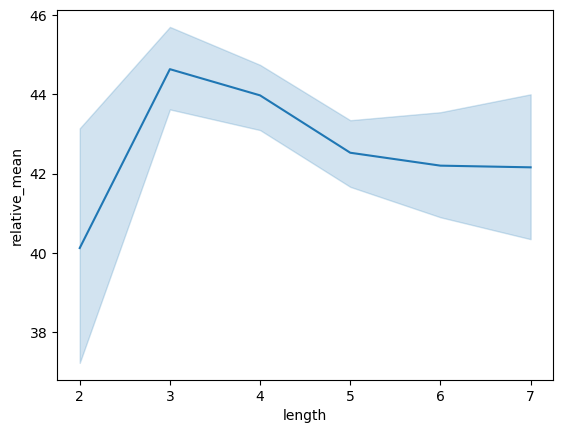

In [37]:
#plot mean against  length
sns.lineplot(data=paths_df, x="length", y="relative_mean", palette="flare",)

/Users/hichemhadhri/miniforge3/envs/ada/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/hichemhadhri/miniforge3/envs/ada/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


<AxesSubplot: xlabel='length', ylabel='relative_mean'>

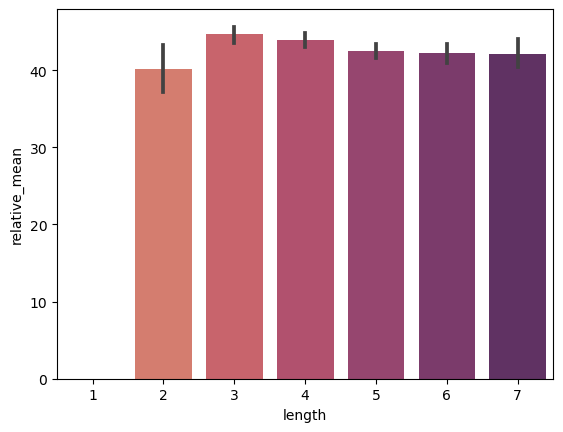

In [38]:
sns.barplot(x="length", y="relative_mean", data=paths_df, palette="flare" )

In [39]:
# groupby start and end node
groups = paths_df.groupby(['start','end']).size().reset_index(name='counts')


In [40]:
groups.sort_values(by=['counts'],ascending=False)

,start,end,counts
2832,Pyramid,Bean,88
319,Asteroid,Viking,64
444,Batman,Wood,53
612,Brain,Telephone,43
3426,Theatre,Zebra,36
...,...,...,...
1341,Fatty_acid,Pythagorean_theorem,1
1342,Fauna_of_Australia,Goa,1
1344,Feather,Crusades,1
1345,Feather,Palladium,1


In [41]:
# number of games with count > 20
len(groups[groups['counts'] > 10])


10

In [42]:
# keep only paths with count > 20
groups = groups[groups['counts'] > 10]
groups.reset_index(drop=True, inplace=True)

In [43]:
groups.reset_index(inplace=True)

In [44]:
groups

,index,start,end,counts
0,0,Asteroid,Viking,64
1,1,Batman,Japan,12
2,2,Batman,Wood,53
3,3,Beer,Sun,32
4,4,Bird,Great_white_shark,29
5,5,Brain,Telephone,43
6,6,Dog,Telephone,11
7,7,Jesus,God,27
8,8,Pyramid,Bean,88
9,9,Theatre,Zebra,36


In [46]:
#get game of path
def get_game(start,end,groups):
    res = groups[(groups['start'] == start) & (groups['end'] == end)]
    if len(res) > 0 : 
        return res['index'].item()
    else :
        return np.nan

In [47]:
# assgin a game number to each path
paths_df['game'] = paths_df.apply(lambda row: get_game(row['start'],row['end'],groups) ,axis=1)





/var/folders/zp/t_7t2xyj4n760sxfr2jkq6z40000gn/T/ipykernel_3508/2361183190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paths_df['game'] = paths_df.apply(lambda row: get_game(row['start'],row['end'],groups) ,axis=1)


In [78]:
paths_df

,path,start,end,length,positions,relative_postions,mean,relative_mean,game
116,"[Batman, Earthquake, Japan]",Batman,Japan,3,"[3, 17]","[50.0, 85.0]",10.000000,67.500000,1.0
117,"[Batman, Earthquake, Japan]",Batman,Japan,3,"[3, 17]","[50.0, 85.0]",10.000000,67.500000,1.0
118,"[Batman, Earthquake, Japan]",Batman,Japan,3,"[3, 17]","[50.0, 85.0]",10.000000,67.500000,1.0
119,"[Batman, Earthquake, Japan]",Batman,Japan,3,"[3, 17]","[50.0, 85.0]",10.000000,67.500000,1.0
120,"[Batman, Scotland, United_Nations, Japan]",Batman,Japan,4,"[1, 29, 37]","[17.0, 26.0, 33.0]",22.333333,25.333333,1.0
...,...,...,...,...,...,...,...,...,...
4493,"[Theatre, Aristotle, Biology, Lion, Zebra]",Theatre,Zebra,5,"[4, 8, 37, 25]","[24.0, 22.0, 71.0, 61.0]",18.500000,44.500000,9.0
4494,"[Theatre, Paris, Africa, Lion, Zebra]",Theatre,Zebra,5,"[8, 28, 25, 25]","[47.0, 25.0, 12.0, 61.0]",21.500000,36.250000,9.0
4495,"[Theatre, Aristotle, Biology, Scientific_class...",Theatre,Zebra,6,"[4, 8, 1, 22, 41]","[24.0, 22.0, 2.0, 88.0, 98.0]",15.200000,46.800000,9.0
4496,"[Theatre, Aristotle, Biology, Lion, Zebra]",Theatre,Zebra,5,"[4, 8, 37, 25]","[24.0, 22.0, 71.0, 61.0]",18.500000,44.500000,9.0


In [48]:
len(paths_df[paths_df['game'].isna()])

4287

In [49]:
games = paths_df[paths_df['game'].notna()]

In [50]:
games

,path,start,end,length,positions,relative_postions,mean,relative_mean,game
1136,"[Batman, Earthquake, Japan]",Batman,Japan,3,"[3, 17]","[50.0, 85.0]",10.000000,67.500000,1.0
1137,"[Batman, Earthquake, Japan]",Batman,Japan,3,"[3, 17]","[50.0, 85.0]",10.000000,67.500000,1.0
1140,"[Batman, Earthquake, Japan]",Batman,Japan,3,"[3, 17]","[50.0, 85.0]",10.000000,67.500000,1.0
1141,"[Batman, Earthquake, Japan]",Batman,Japan,3,"[3, 17]","[50.0, 85.0]",10.000000,67.500000,1.0
1143,"[Batman, Scotland, United_Nations, Japan]",Batman,Japan,4,"[1, 29, 37]","[17.0, 26.0, 33.0]",22.333333,25.333333,1.0
...,...,...,...,...,...,...,...,...,...
40475,"[Theatre, Aristotle, Biology, Lion, Zebra]",Theatre,Zebra,5,"[4, 8, 37, 25]","[24.0, 22.0, 71.0, 61.0]",18.500000,44.500000,9.0
40478,"[Theatre, Paris, Africa, Lion, Zebra]",Theatre,Zebra,5,"[8, 28, 25, 25]","[47.0, 25.0, 12.0, 61.0]",21.500000,36.250000,9.0
40484,"[Theatre, Aristotle, Biology, Scientific_class...",Theatre,Zebra,6,"[4, 8, 1, 22, 41]","[24.0, 22.0, 2.0, 88.0, 98.0]",15.200000,46.800000,9.0
40500,"[Theatre, Aristotle, Biology, Lion, Zebra]",Theatre,Zebra,5,"[4, 8, 37, 25]","[24.0, 22.0, 71.0, 61.0]",18.500000,44.500000,9.0


**Game 1**

In [51]:
game_1 = games[games['game'] == 8]

In [52]:
len(game_1)

88

In [53]:
game_1

,path,start,end,length,positions,relative_postions,mean,relative_mean,game
16845,"[Pyramid, Earth, Plant, Seed, Bean]",Pyramid,Bean,5,"[0, 66, 20, 3]","[0.0, 56.00000000000001, 28.999999999999996, 1...",22.250000,23.750000,8.0
16846,"[Pyramid, Mexico_City, Mestizo, Aztec, Maize, ...",Pyramid,Bean,7,"[7, 7, 31, 14, 12, 4]","[41.0, 19.0, 53.0, 78.0, 24.0, 15.0]",12.500000,38.333333,8.0
16853,"[Pyramid, Mesopotamia, Barley, Plant, Fruit, B...",Pyramid,Bean,6,"[5, 39, 1, 61, 21]","[28.999999999999996, 65.0, 4.0, 87.0, 51.0]",25.400000,47.200000,8.0
16855,"[Pyramid, Sun, Vitamin_D, Vitamin, Rice, Seed,...",Pyramid,Bean,7,"[4, 32, 2, 13, 8, 3]","[24.0, 43.0, 15.0, 48.0, 8.0, 10.0]",10.333333,24.666667,8.0
16856,"[Pyramid, Earth, Plant, Seed, Bean]",Pyramid,Bean,5,"[0, 66, 20, 3]","[0.0, 56.00000000000001, 28.999999999999996, 1...",22.250000,23.750000,8.0
...,...,...,...,...,...,...,...,...,...
17307,"[Pyramid, Mexico, Wine, Fruit, Bean]",Pyramid,Bean,5,"[6, 52, 0, 21]","[35.0, 78.0, 0.0, 51.0]",19.750000,41.000000,8.0
17313,"[Pyramid, France, Currency, Ecuador, Soup, Bean]",Pyramid,Bean,6,"[11, 4, 10, 37, 36]","[65.0, 5.0, 45.0, 88.0, 63.0]",19.600000,53.200000,8.0
17321,"[Pyramid, Mesopotamia, Barley, Bran, Cereal, B...",Pyramid,Bean,7,"[5, 39, 25, 0, 29, 20]","[28.999999999999996, 65.0, 96.0, 0.0, 76.0, 31.0]",19.666667,49.500000,8.0
17323,"[Pyramid, Earth, Plant, Seed, Bean]",Pyramid,Bean,5,"[0, 66, 20, 3]","[0.0, 56.00000000000001, 28.999999999999996, 1...",22.250000,23.750000,8.0


In [54]:
import statsmodels.formula.api as smf

In [55]:
# Parametrize the model 
mod = smf.ols(formula='length ~   relative_mean', data=game_1)
# Fit the model
res = mod.fit()
# Print the summary of the model
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 length   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     26.22
Date:                Thu, 15 Dec 2022   Prob (F-statistic):           1.84e-06
Time:                        19:58:42   Log-Likelihood:                -100.55
No. Observations:                  88   AIC:                             205.1
Df Residuals:                      86   BIC:                             210.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.7057      0.277     24.236

<AxesSubplot: xlabel='length', ylabel='relative_mean'>

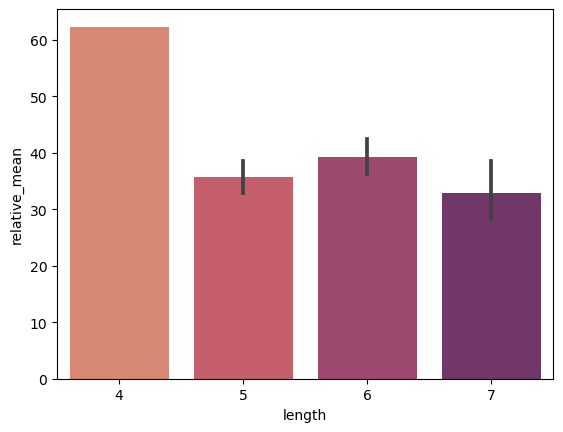

In [56]:
# plot average relative_mean for each path length # with line   
sns.barplot(x="length", y="relative_mean", data=game_1, palette="flare" )

In [57]:
# remove paths with length 1
paths_df = paths_df[paths_df['length'] > 1]

In [58]:
game_1.reset_index(drop=True, inplace=True)

In [59]:
game_1

,path,start,end,length,positions,relative_postions,mean,relative_mean,game
0,"[Pyramid, Earth, Plant, Seed, Bean]",Pyramid,Bean,5,"[0, 66, 20, 3]","[0.0, 56.00000000000001, 28.999999999999996, 1...",22.250000,23.750000,8.0
1,"[Pyramid, Mexico_City, Mestizo, Aztec, Maize, ...",Pyramid,Bean,7,"[7, 7, 31, 14, 12, 4]","[41.0, 19.0, 53.0, 78.0, 24.0, 15.0]",12.500000,38.333333,8.0
2,"[Pyramid, Mesopotamia, Barley, Plant, Fruit, B...",Pyramid,Bean,6,"[5, 39, 1, 61, 21]","[28.999999999999996, 65.0, 4.0, 87.0, 51.0]",25.400000,47.200000,8.0
3,"[Pyramid, Sun, Vitamin_D, Vitamin, Rice, Seed,...",Pyramid,Bean,7,"[4, 32, 2, 13, 8, 3]","[24.0, 43.0, 15.0, 48.0, 8.0, 10.0]",10.333333,24.666667,8.0
4,"[Pyramid, Earth, Plant, Seed, Bean]",Pyramid,Bean,5,"[0, 66, 20, 3]","[0.0, 56.00000000000001, 28.999999999999996, 1...",22.250000,23.750000,8.0
...,...,...,...,...,...,...,...,...,...
83,"[Pyramid, Mexico, Wine, Fruit, Bean]",Pyramid,Bean,5,"[6, 52, 0, 21]","[35.0, 78.0, 0.0, 51.0]",19.750000,41.000000,8.0
84,"[Pyramid, France, Currency, Ecuador, Soup, Bean]",Pyramid,Bean,6,"[11, 4, 10, 37, 36]","[65.0, 5.0, 45.0, 88.0, 63.0]",19.600000,53.200000,8.0
85,"[Pyramid, Mesopotamia, Barley, Bran, Cereal, B...",Pyramid,Bean,7,"[5, 39, 25, 0, 29, 20]","[28.999999999999996, 65.0, 96.0, 0.0, 76.0, 31.0]",19.666667,49.500000,8.0
86,"[Pyramid, Earth, Plant, Seed, Bean]",Pyramid,Bean,5,"[0, 66, 20, 3]","[0.0, 56.00000000000001, 28.999999999999996, 1...",22.250000,23.750000,8.0


In [60]:
# create all posible pairs of paths
pairs_dict = {}
def get_pairs(df):

    
    pairs = []
    counter = 0 
    for i in range(0,len(df)):
        for j in range(0,len(df)):
            if i != j:
                game1 = df.iloc[i]
                game2 = df.iloc[j]

                pairs_dict[counter] = {'game':game1['game'],'start':game1['start'],'end':game1['end'],'length1':game1['length'],'length2':game2['length'],'mean1':game1['mean'],'mean2':game2['mean'],'mean_diff':game1['mean'] - game2['mean'],'winner': 0 if game2['length'] < game1['length'] else 1}
                counter += 1
    #dict to df 
    pairs_df = pd.DataFrame.from_dict(pairs_dict, orient='index')
    return pairs_df

    

In [61]:
paths_df.reset_index(drop=True, inplace=True)

In [62]:
# drop paths with ni game
paths_df = paths_df[paths_df['game'].notna()]

In [63]:
#remove warnings
import warnings
warnings.filterwarnings('ignore')

In [64]:
pairs_df = get_pairs(paths_df)

In [65]:
# drop poaris with same length
pairs_df = pairs_df[pairs_df['length1'] != pairs_df['length2']]

In [66]:
pairs_df

,game,start,end,length1,length2,mean1,mean2,mean_diff,winner
3,1.0,Batman,Japan,3,4,10.0,22.333333,-12.333333,1
4,1.0,Batman,Japan,3,4,10.0,13.000000,-3.000000,1
7,1.0,Batman,Japan,3,5,10.0,41.750000,-31.750000,1
10,1.0,Batman,Japan,3,4,10.0,22.333333,-12.333333,1
11,1.0,Batman,Japan,3,5,10.0,11.000000,-1.000000,1
...,...,...,...,...,...,...,...,...,...
155625,9.0,Theatre,Zebra,7,5,17.5,18.500000,-1.000000,0
155626,9.0,Theatre,Zebra,7,5,17.5,18.500000,-1.000000,0
155627,9.0,Theatre,Zebra,7,5,17.5,21.500000,-4.000000,0
155628,9.0,Theatre,Zebra,7,6,17.5,15.200000,2.300000,0


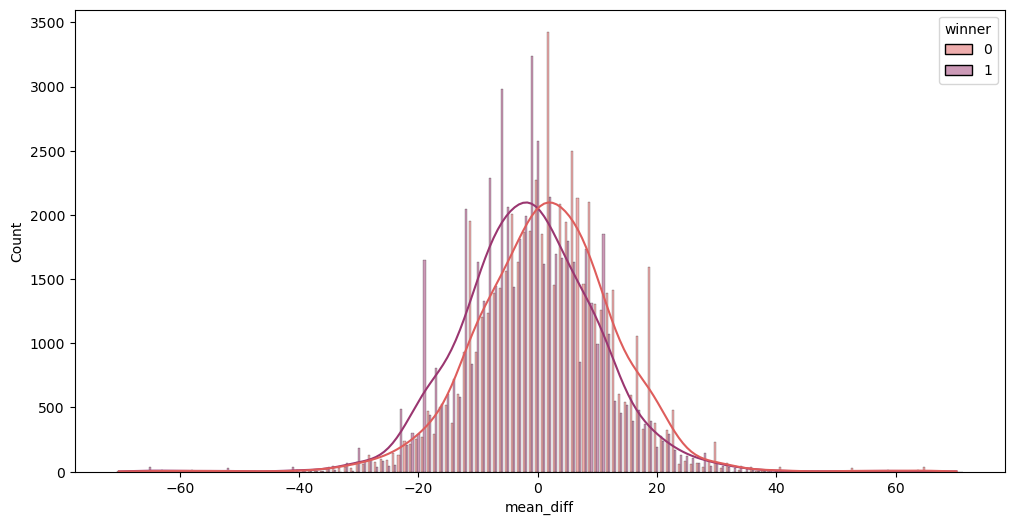

In [79]:
sns.histplot(data=pairs_df, x="mean_diff", hue="winner",bins=35,stat = 'count',discrete= True, shrink=0.7,
  multiple="dodge", palette="flare", kde=True, kde_kws={'bw_method': 0.28})
#make the plot bigger
plt.rcParams['figure.figsize'] = [12, 6]

In [68]:
# add column 

<AxesSubplot: xlabel='mean_diff', ylabel='winner'>

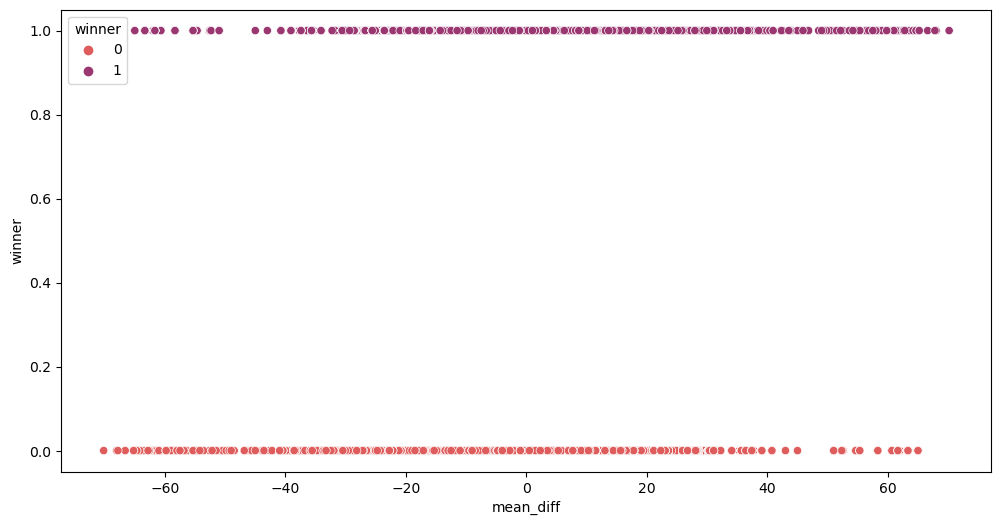

In [69]:
# scatter relative_mean _diff with two colors for winner
sns.scatterplot(data=pairs_df, x="mean_diff", y="winner", hue="winner", palette="flare")

<AxesSubplot: xlabel='winner', ylabel='mean_diff'>

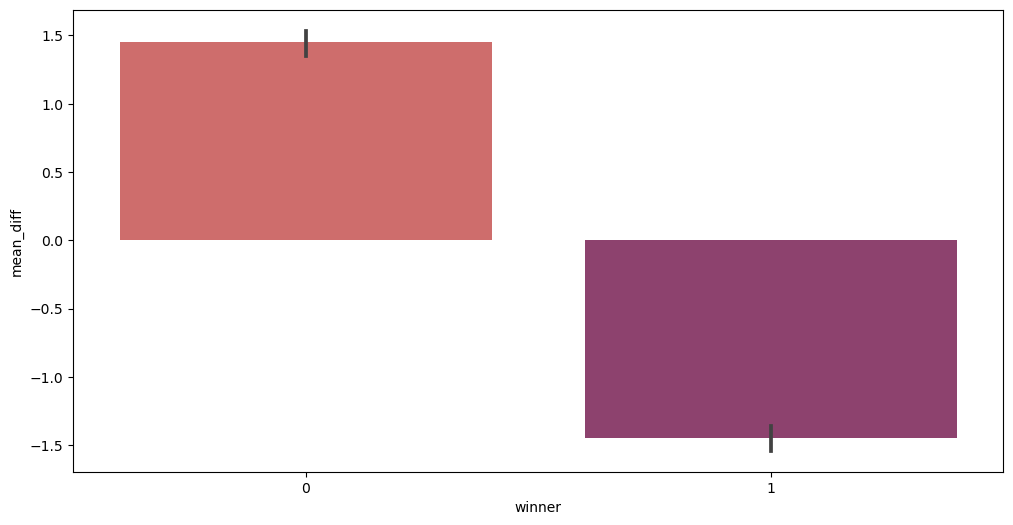

In [70]:
# plot relative_mean_diff against winner
sns.barplot(x="winner", y="mean_diff", data=pairs_df, palette="flare" )